In [1]:
import sys
import numpy as np
from netCDF4 import Dataset, num2date
from ipdb import set_trace as mybreak
import pyicon as pyic
import glob
import pickle
import maps_icon_smt_temp as smt
import datetime
import xarray as xr
import pandas as pd
from icon_smt_levels import dzw, dzt, depthc, depthi

ts = pyic.timing([0], 'start')

### configure paths
run      = 'ngSMT_tke'
savefig  = False
path_fig = '../pics/'
nnf      = 0

gname = 'smt'
lev   = 'L128'

path_data    = f'/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/????-??/'

#####################################################################
### Interpolate temperature to cell surfaces over all layers
levs   = np.arange(depthc.size)
nz     = levs.size
depthc = depthc[levs]

cc        = int(59799625)
nzi       = int(nz+1)

fpatho = '/scratch/u/u241317/calc/pp_calc_T_interp_tave.nc'
fo = Dataset(fpatho, 'w', format='NETCDF4')
#fo.createDimension('depthc', nz) # depth
fo.createDimension('depthi', nzi) 
fo.createDimension('cc', cc) # new dim cell center

nc_T   = fo.createVariable('T','f4',('depthi','cc'))
ncv    = fo.createVariable('depthi','f4','depthi')
ncv[:] = depthi[:nzi]

# --- prepare output netcdf file
ts      = pyic.timing(ts, 'prepare nc')
varfile = 'T_S'
layers  = (  ['sp_001-016']*16 + ['sp_017-032']*16 + ['sp_033-048']*16
          + ['sp_049-064']*16 + ['sp_065-080']*16 + ['sp_081-096']*16 + ['sp_097-112']*16)



xarray
done xarray
0:00:00.060199   0:00:00.060199  prepare nc


In [2]:
pwd

'/mnt/lustre01/pf/zmaw/u241317/notebooks/smt'

In [3]:
# --- load times and flist # only to get time data - it is not the selection of data
time0      = np.datetime64('2010-03-09T01:00:00')
ts         = pyic.timing(ts, 'load times and flist')
search_str = f'{run}_T_S_sp_001-016_*.nc' 
flist      = np.array(glob.glob(path_data+search_str))
flist.sort()
timesd, flist_tsd, itsd = pyic.get_timesteps(flist, time_mode='float2date')



0:00:00.364446   0:00:00.424645  load times and flist


In [71]:
pdtimeitd

Timestamp('2010-03-31 23:00:00')

In [5]:

#only march
path_data = '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/'

interp_coef = 1/(depthc[1:]-depthc[:-1]) * (depthi[1:-1] - depthc[:-1])

for aa, itd in enumerate(range(1,13)):
    #itd     = np.argmin((timesd-time0).astype(float)**2)
    #fpath   = flist_tsd[itd]
    
    pdtimeitd = pd.to_datetime(timesd[itd])
    print(pdtimeitd); print(f'timestep:{itd}');
    tstr      = pdtimeitd.strftime('%Y%m%d')+'T010000Z'
    print(tstr)
    if itd == 1:
        ###  version 2 interpolated
        for kk, lev in enumerate(levs[:-1]):
            ts = pyic.timing(ts, 'loop step')
            if lev == 0:
                # --- load temperature 1 
                fname = f'{run}_{varfile}_{layers[lev]}_{tstr}.nc'
                fpath = f'{path_data}{fname}'
                var   = f'T{lev+1:03d}_sp'
                print(f'kk = {kk}/{nz}; fname = {fname}; var = {var}')
                fi   = Dataset(fpath, 'r')
                T1   = fi.variables[var][itsd[itd],:]
                fi.close()
                # --- load temperature 2 
                fname = f'{run}_{varfile}_{layers[lev+1]}_{tstr}.nc'
                fpath = f'{path_data}{fname}'
                var   = f'T{lev+2:03d}_sp'
                print(f'kk = {kk+1}/{nz}; fname = {fname}; var = {var}')
                fi   = Dataset(fpath, 'r')
                T2   = fi.variables[var][itsd[itd],:]
                fi.close()
                #interpolate
                nc_T[kk+1,:] = T1[:cc] + (T2[:cc]-T1[:cc])*interp_coef[kk]
                # swap fields
                T1 = T2
            else:
                # --- load temperature 2 
                fname = f'{run}_{varfile}_{layers[lev+1]}_{tstr}.nc'
                fpath = f'{path_data}{fname}'
                var   = f'T{lev+2:03d}_sp'
                print(f'kk = {kk+1}/{nz}; fname = {fname}; var = {var}')
                fi   = Dataset(fpath, 'r')
                T2   = fi.variables[var][itsd[itd],:]
                fi.close()
                #interpolate
                nc_T[kk+1,:] = T1[:cc] + (T2[:cc]-T1[:cc])*interp_coef[kk]
                # swap fields
                T1 = T2
            nc_T[:1,:]   = np.NaN
            nc_T[-1:,:]  = np.NaN
        else:
            if lev == 0:
                # --- load temperature 1 
                fname = f'{run}_{varfile}_{layers[lev]}_{tstr}.nc'
                fpath = f'{path_data}{fname}'
                var   = f'T{lev+1:03d}_sp'
                print(f'kk = {kk}/{nz}; fname = {fname}; var = {var}')
                fi   = Dataset(fpath, 'r')
                T1   = fi.variables[var][itsd[itd],:]
                fi.close()
                # --- load temperature 2 
                fname = f'{run}_{varfile}_{layers[lev+1]}_{tstr}.nc'
                fpath = f'{path_data}{fname}'
                var   = f'T{lev+2:03d}_sp'
                print(f'kk = {kk+1}/{nz}; fname = {fname}; var = {var}')
                fi   = Dataset(fpath, 'r')
                T2   = fi.variables[var][itsd[itd],:]
                fi.close()
                #interpolate
                T_temp = T1[:cc] + (T2[:cc]-T1[:cc])*interp_coef[kk]
                # average and save
                nc_T[kk+1,:] =   (nc_T[kk+1,:] * 1/(itd-1) + T_temp)/itd
                # swap fields
                T1 = T2
            else:
                # --- load temperature 2 
                fname = f'{run}_{varfile}_{layers[lev+1]}_{tstr}.nc'
                fpath = f'{path_data}{fname}'
                var   = f'T{lev+2:03d}_sp'
                print(f'kk = {kk+1}/{nz}; fname = {fname}; var = {var}')
                fi   = Dataset(fpath, 'r')
                T2   = fi.variables[var][itsd[itd],:]
                fi.close()
                #interpolate
                T_temp = T1[:cc] + (T2[:cc]-T1[:cc])*interp_coef[kk]
                # average and save
                nc_T[kk+1,:] =   (nc_T[kk+1,:] * 1/(itd-1) + T_temp)/itd
                # swap fields
                T1 = T2
            nc_T[:1,:]   = np.NaN
            nc_T[-1:,:]  = np.NaN
            

fo.close()


2010-01-09 03:00:00
timestep:1
20100109T010000Z
0:02:01.310135   0:13:30.871089  loop step
kk = 0/112; fname = ngSMT_tke_T_S_sp_001-016_20100109T010000Z.nc; var = T001_sp
kk = 1/112; fname = ngSMT_tke_T_S_sp_001-016_20100109T010000Z.nc; var = T002_sp
0:00:04.911556   0:13:35.782645  loop step
kk = 2/112; fname = ngSMT_tke_T_S_sp_001-016_20100109T010000Z.nc; var = T003_sp
0:00:03.325413   0:13:39.108058  loop step
kk = 3/112; fname = ngSMT_tke_T_S_sp_001-016_20100109T010000Z.nc; var = T004_sp
0:00:03.385473   0:13:42.493531  loop step
kk = 4/112; fname = ngSMT_tke_T_S_sp_001-016_20100109T010000Z.nc; var = T005_sp
0:00:03.244820   0:13:45.738351  loop step
kk = 5/112; fname = ngSMT_tke_T_S_sp_001-016_20100109T010000Z.nc; var = T006_sp
0:00:03.257685   0:13:48.996036  loop step
kk = 6/112; fname = ngSMT_tke_T_S_sp_001-016_20100109T010000Z.nc; var = T007_sp
0:00:03.269421   0:13:52.265457  loop step
kk = 7/112; fname = ngSMT_tke_T_S_sp_001-016_20100109T010000Z.nc; var = T008_sp
0:00:03.321

KeyboardInterrupt: 

In [24]:
tstr

'20100331T010000Z'

In [ ]:
fpath_ckdtree = '/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/icon_ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'
ds = xr.open_dataset('/scratch/u/u241317/calc/pp_calc_T_interp_tave.nc')
t = ds.T.isel(depthi=10)

In [57]:
t.T

<xarray.DataArray 'T' (cc: 59799625)>
[59799625 values with dtype=float32]
Coordinates:
    depthi   float32 32.0
Dimensions without coordinates: cc

In [58]:
#choose plot region
lon_reg_2 = [-75, -55]
lat_reg_2 = [33, 43]

toi.min() %d 9.96921e+36
toi.max() %d 9.96921e+36
CPU times: user 4.45 s, sys: 4.6 s, total: 9.05 s
Wall time: 11.7 s


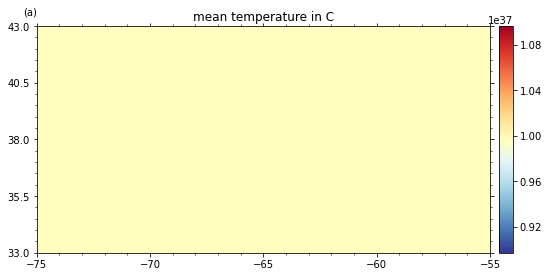

In [59]:
%%time
lon, lat, toi = pyic.interp_to_rectgrid(t.T, fpath_ckdtree, lon_reg=lon_reg_2, lat_reg=lat_reg_2)

hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=0.5, fig_size_fac=2.)
print('toi.min() %d', toi.min()); print('toi.max() %d', toi.max())  
clim = 0.015
ii=-1

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, toi, ax=ax, cax=cax, rasterized=False)

ax.set_title('mean temperature in C')


for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg_2, ylim=lat_reg_2)

In [84]:
for aa, itd in enumerate(range(1,13)):
    print(f'timestep:{itd}')

timestep:1
timestep:2
timestep:3
timestep:4
timestep:5
timestep:6
timestep:7
timestep:8
timestep:9
timestep:10
timestep:11
timestep:12
